### Setup

In [1]:
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\bergermann\.julia\registries\General.toml`


    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`


    Updating git-repo `https://github.com/bergermann/Dragoon.jl.git`

    Updating `C:\Users\bergermann\.julia\environments\v1.9\Project.toml`
  [2528b1d8] ~ Dragoon v0.0.0 `https://github.com/bergermann/Dragoon.jl.git#main` ⇒ v0.0.0 `https://github.com/bergermann/Dragoon.jl.git#main`
    Updating `C:\Users\bergermann\.julia\environments\v1.9\Manifest.toml`


  [2528b1d8] ~ Dragoon v0.0.0 `https://github.com/bergermann/Dragoon.jl.git#main` ⇒ v0.0.0 `https://github.com/bergermann/Dragoon.jl.git#main`

Precompiling project...


  ✓ Dragoon
  1 dependency successfully precompiled in 15 seconds. 151 already precompiled.


In [2]:
using Dragoon
using Plots

In [3]:
#number of discs in the booster
n = 20

#initial disc configuration
#findpeak tries to find an equidistant configuration with a peak at f
initdist = findpeak(22.025e9,n)

#generate frequencies for calculation and for plotting
freqs = genFreqs(22.025e9,50e6; length=10) #optimize on these frequencies
freqsplot = genFreqs(22.025e9,150e6; length=1000)

#initialize physical properties of the booster
booster = AnalyticalBooster(initdist)
#=
Booster(
    pos,              disc positions
    ndisk,            disc number
    thickness,        disc thickness
    epsilon,          disc epsilon
    vmotor,           motor speed
    maxlength,        maximum allowed booster length (not implemented yet)
    timestamp,        booster operation time
    summedtraveltime, summed motor operation time
    codetimestamp     code runtime
)
=#

#initialize storage of measurements
hist = initHist(booster,10000,freqs,ObjAnalytical)
#                           ^ length, should be at least the larger of (n^2, search steps)
;

Objective Value: -243.3, Timestamp: 2023-06-19T09:34:09.381


### Optimizer

In [4]:
#=
how to use

linesearch(                     directly modifies booster.pos
    booster,                    
    hist,                       
    freqs,                      frequency range to optimize on
    α,                          base step length e.g. motorspeed*measurementfrequency
    (objective,[options]),      objective function
    (solver,[options]),         provides step direction p
    (derivative,[options]),     provides derivatives for use by solver
    (step,[options]),           calculates steplength
    (search,[options]),         search mode
    (unstuckinator,[options]);  tries to unstuck system from bad local minima
    ϵgrad=0,                    terminate if norm(gradient) falls below this value,
    maxiter=100,                maximum allowed iterations,
    showtrace=false,            wether to print progress,
    showevery=1,                only print every i iterations,
    unstuckisiter=true          wether an unstucking iteration counts towards maxiter
                                    warning! can run endlessly if false
)

returns trace, access with
trace[iteration].x      disc position
                .obj    objective value
                .g      gradient
                .h      hessian
                .t      timestamp
                .T      summed travel time
=#

In [5]:
trace = linesearch(booster,hist,freqs,booster.vmotor*1e-3,
                    ObjAnalytical,
                    SolverNewton("inv"),
                    Derivator2(1e-5,1e-6,"double"),
                    StepNorm("unit"),
                    SearchExtendedSteps(2000),
                    UnstuckDont;
                    ϵgrad=0.,maxiter=Int(2e1),showtrace=true);

20-element Vector{Float64}:
       1.172259922511597e6
       1.3621222594415839e6
       1.4067977735977848e6
       1.2913148034140249e6
       1.0219178004336256e6
  625438.7503142765
  145594.43266451807
 -363011.54934549937
 -842014.6635360054
      -1.236510959426141e6
      -1.5017226790724648e6
      -1.6086437626539718e6
      -1.5480509099341857e6
      -1.3320708223026115e6
 -992674.7903975367
 -577126.6084924107
 -141184.30231015678
  258717.45742559395
  573129.2113975214
  766175.3401058959

20×20 Matrix{Float64}:
 -1.13652e13  -5.17149e9   -6.66812e9   …  -1.53564e9   -3.26113e9
 -5.17149e9   -4.10286e12  -7.60794e9      -1.87565e9   -3.82256e9
 -6.66812e9   -7.60794e9   -4.24792e12     -2.05048e9   -3.99158e9
 -7.43909e9   -8.44713e9   -8.48817e9      -2.01767e9   -3.71884e9
 -7.35717e9   -8.31262e9   -8.30117e9      -1.76081e9   -3.0116e9
 -6.40487e9   -7.18964e9   -7.12067e9   …  -1.29232e9   -1.93355e9
 -4.6775e9    -5.19181e9   -5.06757e9      -6.52286e8   -5.97445e8
 -2.3722e9    -2.54791e9   -2.37794e9       9.60997e7    8.48651e8
  2.3615e8     4.2614e8     6.2603e8        8.74156e8    2.23993e9
  2.82979e9    3.36746e9    3.57706e9       1.59736e9    3.41603e9
  5.08978e9    5.91385e9    6.11113e9   …   2.18599e9    4.24218e9
  6.73923e9    7.75299e9    7.91695e9       2.5754e9     4.62737e9
  7.58193e9    8.66594e9    8.7794e9        2.72461e9    4.53673e9
  7.53004e9    8.55816e9    8.6099e9        2.62189e9    3.99624e9
  6.61633e9    7.47258e9    7.45878e9   

20-element Vector{Float64}:
 1.0318792402320894e-7
 3.3250361266992314e-7
 3.3167121210828676e-7
 3.2989356666927495e-7
 3.2643625576843186e-7
 3.1847989407413245e-7
 2.6929342618121707e-7
 3.6531404484257145e-7
 3.443987340044967e-7
 3.386595655370096e-7
 3.359199818553318e-7
 3.3444252643455816e-7
 3.3366968346554885e-7
 3.333159180446065e-7
 3.331475624502485e-7
 3.327383406886271e-7
 3.280598146430252e-7
 3.388916508648977e-7
 3.3694043255026e-7
 3.362631397770658e-7

20-element Vector{Float64}:
 0.07111827059401252
 0.22916520632809362
 0.2285915065570647
 0.22736633345131038
 0.2249835161352213
 0.21949990272526693
 0.18560003928402466
 0.25177852291188363
 0.23736345690662586
 0.2334079578507134
 0.2315198061562895
 0.2305015273664038
 0.2299688753539036
 0.22972505627166556
 0.2296090237142815
 0.22932698350219813
 0.22610249105851438
 0.23356791365276958
 0.2322231121810665
 0.23175631443151043

Gradient norm: 4.69e6

20-element Vector{Float64}:
       1.274631634030331e6
       1.8896102087695794e6
       2.0988724105824814e6
       2.0664697776660202e6
       1.7788207701039282e6
       1.2443501282934789e6
  312849.730982569
  121967.42804498796
 -739562.9163074574
      -1.4402069939791032e6
      -1.9676603718994071e6
      -2.272266024369816e6
      -2.3253505334795504e6
      -2.1284822551269713e6
      -1.7146050927922628e6
      -1.1435763553351818e6
 -490448.1132709179
  141142.22599025935
  692359.710122551
       1.0831307472245442e6

20×20 Matrix{Float64}:
 -1.4906e13  -4.99908e9   -7.11125e9   …  -9.80177e8   -3.29902e9
 -4.99908e9  -5.68396e12  -1.03916e10     -1.5691e9    -4.93016e9
 -7.11125e9  -1.03916e10  -6.32343e12     -1.90557e9   -5.53715e9
 -8.44342e9  -1.22929e10  -1.33561e10     -2.07022e9   -5.52888e9
 -8.77449e9  -1.2731e10   -1.3771e10      -2.01352e9   -4.85553e9
 -7.97014e9  -1.15158e10  -1.23889e10  …  -1.70157e9   -3.52056e9
 -5.39859e9  -7.7312e9    -8.22012e9      -9.42952e8   -1.10241e9
 -4.81917e9  -6.86502e9   -7.24728e9      -8.28619e8   -6.19524e8
 -1.48135e9  -1.99226e9   -1.93423e9       5.82386e7    1.69567e9
  1.752e9     2.71031e9    3.16867e9       9.00813e8    3.62672e9
  4.70918e9   6.99346e9    7.7916e9    …   1.67619e9    5.13128e9
  7.05681e9   1.03743e10   1.14133e10      2.30935e9    6.06446e9
  8.51987e9   1.24569e10   1.36096e10      2.73411e9    6.33639e9
  8.93696e9   1.30118e10   1.41391e10      2.90686e9    5.93763e9
  8.2858e9    1.20127e10   1.2982e10       2.81341e9 


Iter: 1, timestamp: 22 seconds
Iter finished. Steps: 2000, Objective value: -361.75



20-element Vector{Float64}:
 8.554311971197767e-8
 3.329332240229515e-7
 3.324411158640305e-7
 3.3117211356340175e-7
 3.2863962316253225e-7
 3.2332462986445093e-7
 2.8791333213882934e-7
 2.3123199012353238e-7
 3.5474266737078957e-7
 3.415670872966616e-7
 3.371267791622534e-7
 3.3493065580235767e-7
 3.3377810185167057e-7
 3.3322371319041135e-7
 3.3300875046094824e-7
 3.3286280622585254e-7
 3.3186199019251945e-7
 3.4324835887848776e-7
 3.3660210729383605e-7
 3.359010430535411e-7

20-element Vector{Float64}:
 0.059690268246567785
 0.23231410681579387
 0.23197072364118881
 0.23108523936162217
 0.22931811850060227
 0.22560942308758283
 0.20090013182817756
 0.16134903150754243
 0.24753229768986948
 0.2383386429391799
 0.2352402852391961
 0.23370787453338948
 0.2329036455700691
 0.23251680431369645
 0.23236680764502374
 0.23226497069342278
 0.23156662139664405
 0.23951180043042442
 0.23487417976311914
 0.2343849912380551

Gradient norm: 6.82e6

20-element Vector{Float64}:
       1.3967060481502612e6
       2.0546665609651483e6
       2.2386733518099645e6
       2.2754005563512747e6
       2.1474735361859044e6
       1.8469218308393748e6
  543072.436412811
 -175452.4118568156
 -399591.49800733366
      -1.5321141734816704e6
      -2.4003689394744127e6
      -2.675726373183158e6
      -2.65792284352392e6
      -2.4637902165800454e6
      -2.111419765844536e6
      -1.6329486927811045e6
 -962327.777944327
  -65451.169679670325
  774149.2568122481
       1.4128364259393606e6

20×20 Matrix{Float64}:
 -1.86325e13  -5.27648e9   -8.06812e9   …  -4.76162e8   -3.39804e9
 -5.27648e9   -7.63082e12  -1.44989e10     -1.00414e9   -6.22241e9
 -8.06812e9   -1.44989e10  -8.98314e12     -1.40023e9   -7.39877e9
 -9.95797e9   -1.78446e10  -2.06021e10     -1.70895e9   -7.74612e9
 -1.06284e10  -1.89995e10  -2.1863e10      -1.85861e9   -7.1398e9
 -9.84188e9   -1.75434e10  -2.01091e10  …  -1.78129e9   -5.5116e9
 -6.22304e9   -1.10159e10  -1.25056e10     -1.17021e9   -1.73536e9
 -4.19247e9   -7.35602e9   -8.24671e9      -8.75925e8    3.26415e7
 -3.41197e9   -5.94083e9   -6.5863e9       -7.92343e8    5.84657e8
  6.9037e8     1.40404e9    1.88441e9       1.70607e7    3.50486e9
  4.41702e9    8.05722e9    9.52751e9   …   8.30268e8    5.81635e9
  7.49247e9    1.35278e10   1.57804e10      1.5993e9     7.41335e9
  9.57899e9    1.72153e10   1.99573e10      2.24813e9    8.15519e9
  1.04485e10   1.87175e10   2.16034e10      2.70764e9    7.9905e9
  1.00301e10   1.79137e10   2.059e10      


Iter: 2, timestamp: 44 seconds
Iter finished. Steps: 2000, Objective value: -491.65



20-element Vector{Float64}:
 7.493546491471504e-8
 2.694472980066019e-7
 2.494304503588225e-7
 2.447246945416883e-7
 2.5367619797375675e-7
 2.879028752960053e-7
 2.9770466134580813e-7
 5.072861841920414e-7
 3.929260858937823e-7
 3.4487795516531123e-7
 3.382755904489915e-7
 3.025517073497994e-7
 2.787192552613987e-7
 2.6975018918025633e-7
 2.7309289020317003e-7
 2.942210381538615e-7
 3.333236133426505e-7
 3.214938059614117e-7
 3.3622330815820274e-7
 3.358059593624227e-7

20-element Vector{Float64}:
 0.05401394981877532
 0.19421929055751075
 0.17979102210534673
 0.1763990840042703
 0.1828513834292839
 0.20752218561155358
 0.21458737404310568
 0.3656550410128477
 0.2832235699092448
 0.24859017802988168
 0.24383115242193462
 0.21808115499084316
 0.20090257509377682
 0.19443761640192822
 0.19684705611804018
 0.21207635674987238
 0.24026173648209834
 0.23173473764405503
 0.24235185456484135
 0.24205102695353814

Gradient norm: 8.0e6


20-element Vector{Float64}:
  583030.4939302208
       1.06991087899178e6
       1.2618858154846379e6
       1.304440226660867e6
       1.1813619295081024e6
  888761.6940044409
  240149.7746411678
  -51688.23875848147
 -272190.4348788456
      -1.172577852213763e6
      -1.529700735069207e6
      -1.7186177275297323e6
      -1.7163355019947544e6
      -1.526827330839029e6
      -1.1708839071599839e6
 -683944.5751105301
 -107235.67296012389
  466405.6830580648
       1.0430240711992837e6
       1.5148983489493132e6

20×20 Matrix{Float64}:
 -1.89905e13   3.62483e10   3.3449e10   …  -5.5994e11   -1.29995e11
  3.62483e10  -7.65149e12   2.69292e10     -5.60398e11  -1.32876e11
  3.3449e10    2.69292e10  -9.0458e12      -5.60774e11  -1.34078e11
  3.1535e10    2.34901e10   2.06747e10     -5.61088e11  -1.34451e11
  3.08108e10   2.22198e10   1.92775e10     -5.61272e11  -1.33881e11
  3.14806e10   2.3484e10    2.08138e10  …  -5.61263e11  -1.32327e11
  3.49888e10   2.99057e10   2.83152e10     -5.60762e11  -1.28558e11
  3.64948e10   3.2666e10    3.15452e10     -5.60607e11  -1.27192e11
  3.75106e10   3.45304e10   3.37316e10     -3.64069e11  -1.264e11
 -9.78442e11  -9.77944e11  -9.77533e11      1.8642e9     1.74119e9
 -1.61258e12  -2.05693e12  -2.05547e12  …   1.46678e9    1.28274e9
 -1.61245e12  -2.87012e12  -2.8678e12       9.89362e8    7.39997e8
 -1.61234e12  -3.00494e12  -3.31783e12      4.67511e8    1.49492e8
 -1.61224e12  -3.00475e12  -3.39003e12     -8.94275e7   -4.79017e8
 -1.61215e12  -3.00459e12  -3.12

Iter: 3, timestamp: 1 minute, 6 seconds
Iter finished. Steps: 190, Objective value: -508.916



20-element Vector{Float64}:
 -4.279758576838631e-8
 -3.3383382111184706e-9
  4.6608705960554585e-8
  4.9242833520844784e-8
  3.888483787114628e-8
 -5.018220929515207e-8
 -4.86343842081146e-7
 -3.250640106965153e-6
  1.247781691736338e-6
 -4.4577949289788655e-7
 -2.9101352524108446e-7
 -9.462003058651493e-8
 -1.3224670478345244e-6
  2.821815190466836e-7
  4.549233172227844e-7
  5.853701390260243e-7
  6.690037235840404e-7
  7.332070332008256e-7
  6.673885617871787e-7
  3.8521082182646075e-7

20-element Vector{Float64}:
 -0.01049790233296095
 -0.0008188674165962113
  0.011432739353279783
  0.012078869581516015
  0.009538136856912394
 -0.012309290876445972
 -0.119296218764196
 -0.7973557795340238
  0.30607077706660946
 -0.10934611133919864
 -0.07138326872185999
 -0.023209529743445256
 -0.3243904920679244
  0.06921684889307107
  0.11158901763844688
  0.14358657007859255
  0.16410121329227653
  0.17984976690129187
  0.16370502714086263
  0.09448910522707467

Gradient norm: 4.95e6


Iter: 4, timestamp: 1 minute, 30 seconds
Iter finished. Steps: 0, Objective value: -508.916

Stuck. Trying to unstuck.

No unstucking tried. Terminating.
Terminated. 4 Iterations.
Final objective value: -508.916
Elapsed movement time:  1 minute, 31 seconds
Summed movement time:   2 minutes, 53 seconds
Elapsed computing time: 9 seconds, 241 milliseconds

In [7]:
booster.timestamp

0000-01-01T00:01:30.655

In [8]:
Dragoon.move(booster,1e-3*ones(20); additive=true)

In [9]:
#obtain result, booster is now in optimized position
#pos2dist(booster.pos)     #in distance space
booster.pos               #in position space

20-element Vector{Float64}:
 0.008236902984112705
 0.016515416051745058
 0.024724673509350738
 0.03293390194234889
 0.041142909559700444
 0.049351254854467994
 0.05754938227340913
 0.0657672930470347
 0.07398979550043558
 0.08219622264651796
 0.09040484993445015
 0.09861356555788987
 0.10682268679996633
 0.11503215284499897
 0.1232418604297948
 0.13145178802235657
 0.13966125398757206
 0.14787388910616767
 0.15608260935827994
 0.16429212745657082

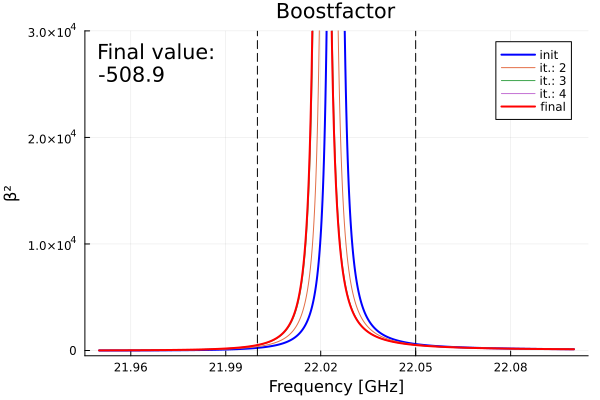

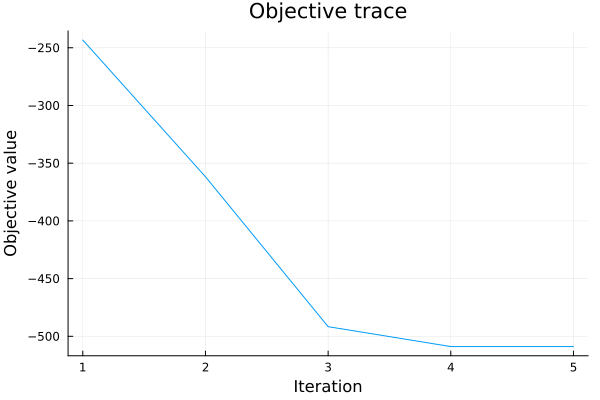

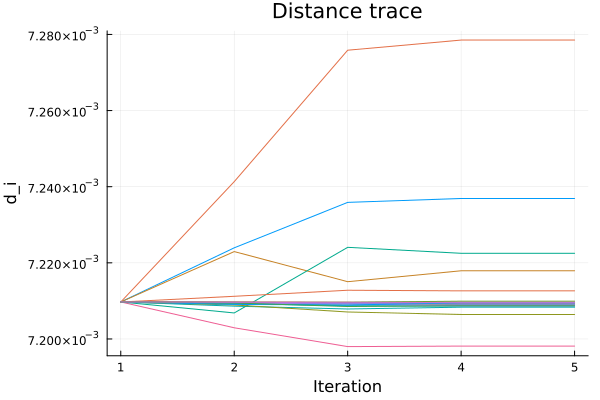

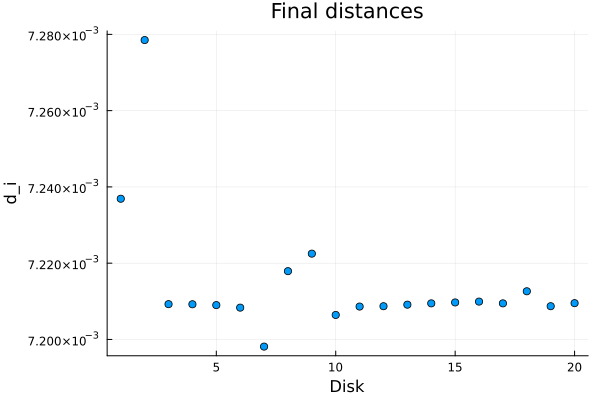

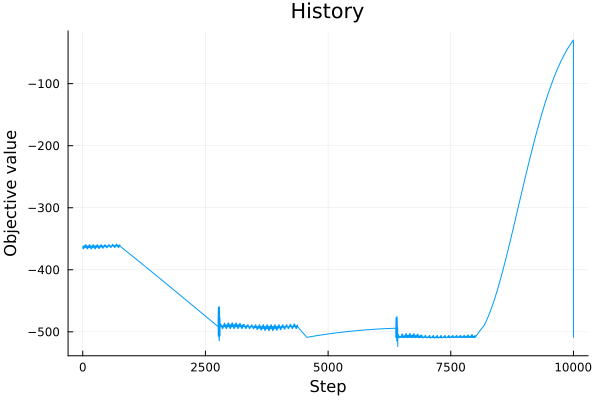

(Plot{Plots.GRBackend() n=6}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=20}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=1})

In [10]:
#get handy output
plt = analyse(hist,trace,freqsplot; freqs=freqs,div=10)

#savefig(plt[i],"cool_epic_result_wow.svg")